# Singular Spectrum Analysis for Climate Timeseries

The normal way of the world is for climate scientists to borrow tools developed in other, more established disciplines. This is particularly so when it comes to timeseries analysis techniques, which have largely been developed by electrical engineers or financial mathematicians. 

Singular Spectrum Analysis (SSA) is the exception that confirms the rule. Introduced by [Vautard & Ghil, (1989)](https://www.sciencedirect.com/science/article/pii/016727899290103T), it is a method steeped in the theory of dynamical systems, designed specifically for the short and noisy timeseries that paleogeoscientists - particular, paleoclimatologists - love so. (yes, even if a record reaches back to the precambrian, it is "short" if the number of points is less than a few hundred samples). Unlike Fourier or wavelet analysis, and like principal component analysis, SSA extracts patterns of variations from the data themselves (using an [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix)), then projects the data on these eigenvectors. In effect, SSA replaces Fourier's sines/cosines, or wavelets, by oscillations it pulls out of data. The advantage is that those patterns came from the data, so they are (by construction) well suited to describing the data in question. The disadvantage is that some data must be sacrificed to find these patterns in the first place (unlike parametric methods like Fourier or wavelet analysis, where they are imposed). There is no free lunch! 


In this notebook, we illustrate how to apply SSA on the monthly NINO3 series using the `Pyleoclim` package. We highlight three specific applications: reconstruction, pre-filtering, and imputation of missing values (interpolation). 

Caveat emptor: like the vast majority of timeseries techniques, this one assumes that the data are evenly-spaced. If you want to apply SSA to an unevenly-spaced series, you will need to cast it onto a regular time grid, using [NaNs](https://en.wikipedia.org/wiki/NaN) to signal missing values. SSA does allow modest amounts of missing values in the timeseries, though they should not be present in large contiguous blocks (see last section, below). 


## SSA with NINO3

We start by importing relevant packages, loading and plotting the timeseries of interest (NINO3). To simplify matters, let's standardize this timeseries (give it zero mean and unit standard deviation). 

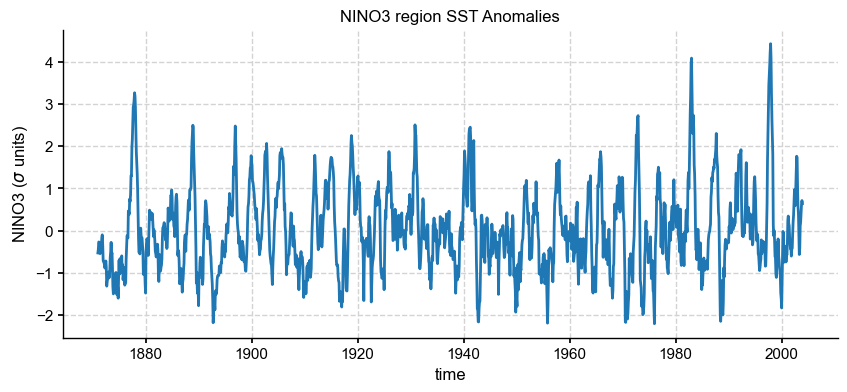

In [1]:
%load_ext autoreload
%autoreload 2
import pyleoclim as pyleo
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

data = sio.loadmat('./data/wtc_test_data_nino.mat')
nino = data['nino'][:, 0]
t = data['datayear'][:, 0]
ts_nino = pyleo.Series(time=t, value=nino)
ts_n    = ts_nino.standardize()
fig, ax = ts_n.plot(title='NINO3 region SST Anomalies',mute=True)
ax.set_ylabel(r'NINO3 ($\sigma$ units)')
pyleo.showfig(fig)

Let us now apply SSA to this series. While SSA is non-parametric, it does rely on one crucial parameter, the **embedding dimension**, denoted $M$, which describes the width of the window over which SSA will hunt for oscillations. It has been shown that SSA can well identify oscillations with a period between $M/5$ and $M$.  By default, `pyleoclim` will use a default of 10% of the timeseries, in this case 159 months. In order to focus on interannual modes, let's use 60 months (5 years), in accord with [Ghil et al (2002)](https://doi.org/10.1029/2000RG000092).  

In [2]:
nino_ssa = ts_n.ssa(M = 60)
nino_ssa.keys()  # identify the output

dict_keys(['eigvals', 'eigvecs', 'PC', 'RCseries', 'RCmat', 'pctvar', 'eigvals_q'])

SSA returns 4 or 5 arrays, depending on the value of MC:
- **eigvals** is a diagonal matrix of eigenvalues of length $r$, the number of SSA modes. As in Principal Component Analysis, eigenvalues $\lambda_i, i \in \lbrace 1 , \cdots , r \rbrace$ are closely related to the fraction of variance accounted for ("explained", a common but not-so-helpful term) by each mode.
- **eigvecs**, is a matrix of the temporal eigenvectors (T-EOFs), i.e. the temporal patterns that explain most of the variations in the original series.
- **PC** is a matrix of  principal components, i.e. the loadings that, convolved with the T-EOFs, produce the reconstructed components, or RCs
- **RC**, the matrix of said reconstructed components. One can think of each RC as the contribution of each mode to the timeseries, weighted by their eigenvalue (loosely speaking, their "amplitude"). Summing over all columns of RC recovers the original series. (synthesis, the reciprocal operation of analysis). 
- **eigvals_q**, if MC > 0 (see below). Right now, it is empty.

Let us now see how to make use of all these arrays. The first step is too inspect the eigenvalue spectrum ("[scree plot](https://en.wikipedia.org/wiki/Scree_plot)") to identify remarkable modes. Let us restrict ourselves to the first 40, so we can see something:

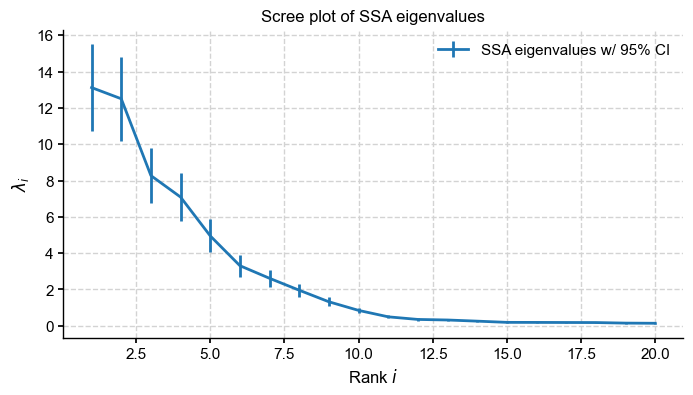

In [3]:
d  = nino_ssa['eigvals'] # extract eigenvalue vector
M  = len(d)  # infer window size
de = d*np.sqrt(2/(M-1))
var_pct = d**2/np.sum(d**2)*100  # extract the fraction of variance attributable to each mode

# plot eigenvalues
r = 20
rk = np.arange(0,r)+1
fig = plt.figure(figsize=(8,4))
plt.errorbar(rk,d[:r],yerr=de[:r],label='SSA eigenvalues w/ 95% CI')
plt.title('Scree plot of SSA eigenvalues')
plt.xlabel('Rank $i$'); plt.ylabel(r'$\lambda_i$')
plt.legend(loc='upper right')
pyleo.showfig(fig)

This highlights a few common phenomena with SSA:
1. the eigenvalues are in descending order
1. their uncertainties are proportional to the eigenvalues themselves
1. the eigenvalues tend to come in pairs : (1,2) (3,4),  are all clustered within uncertainties . (5,6) looks like another doublet
1. around $i=15$, the eigenvalues appear to reach a floor, and all subsequent eigenvalues explain a very small amount of variance.

Indeed, the variance explained by mode $i$ is  $$ v_i = \frac{{\lambda_i}^2}{\sum_{k=0}{M} {\lambda_k}^2} $$. So, summing the variance of all modes higher than 19, we get:

In [4]:
print(var_pct[15:].sum()*100)

4.825612144779392


That is, over 95% of the variance is in the first 15 modes; almost all of it in the first 10 modes. That is a typical result for a "warm-colored" timeseries, which is most geophysical timeseries; a few modes do the vast majority of the work. That means we can focus our attention on these modes and capture most of the interesting behavior. To see this, let's use the reconstructed components (RCs), and sum the RC matrix over the first 10 columns:

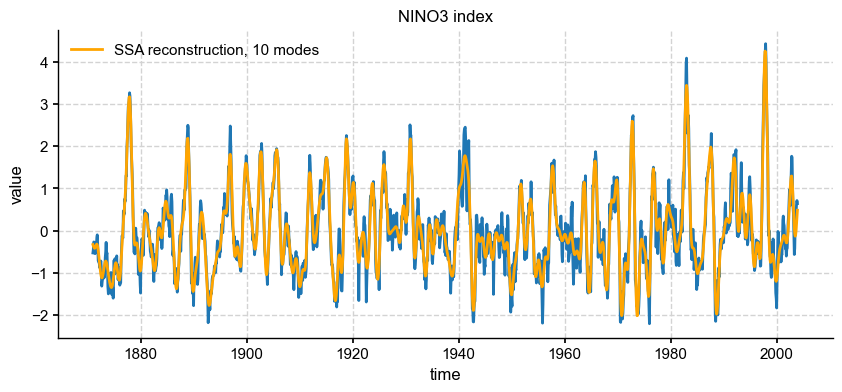

In [5]:
RCk = nino_ssa['RCmat'][:,:9].sum(axis=1)
fig, ax = ts_n.plot(title='NINO3 index',mute=True) # we mute the first call to only get the plot with 2 lines
ax.plot(t,RCk,label='SSA reconstruction, 10 modes',color='orange')
ax.legend()
pyleo.showfig(fig)

Indeed, these first few modes capture the vast majority of the low-frequency behavior, including all the El Niño/La Niña events. What is left (the blue wiggles not captured in the orange curve) are high-frequency oscillations that might be considered "noise" from the standpoint of ENSO dynamics. This illustrates how SSA might be used for filtering a timeseries. One must be careful however: 

1. there was not much rhyme or reason for picking 10 modes. Why not 5, or 39? All we have seen so far is that they gather >95% of the variance, which is by no means a magic number.
1. there is no guarantee that the first few modes will filter out high-frequency behavior, or at what frequency cutoff they will do so. If you need to cut out specific frequencies, you are better off doing it with a classical filter, like the butterworth filter implemented in Pyleoclim. However, in many instances the choice of a cutoff frequency is itself rather arbitrary. In such cases, SSA provides a principled alternative for generating a version of a timeseries that preserves features and excludes others (i.e, a filter). 
1. as with all orthgonal decompositions, summing over all RCs will recover the original signal within numerical precision.


## Monte-Carlo SSA

Selecting meanginful modes in eigenproblems (e.g. EOF analysis) is more art than science. However, one technique stands out: Monte Carlo SSA, introduced by [Allen & Smith, (1996)](https://doi.org/10.1175/1520-0442(1996)009%3C3373:MCSDIO%3E2.0.CO;2) to identiy SSA modes that rise above what one would expect from "red noise", specifically an [AR(1) process](https://en.wikipedia.org/wiki/Autoregressive_model#Example:_An_AR(1)_process). To run it, simply provide the parameter $MC$, ideally with a number of iterations sufficient to get decent statistics. Here's let's use $MC = 1000$. The result will be stored in the **eigvals_q** array, which has the same length as `eigvals`, and its two columns contain the 5% and 95% quantiles of the ensemble of MC-SSA eigenvalues. 

In [6]:
nino_mcssa = ts_n.ssa(M = 60, nMC=1000)

Now let's look at the result:

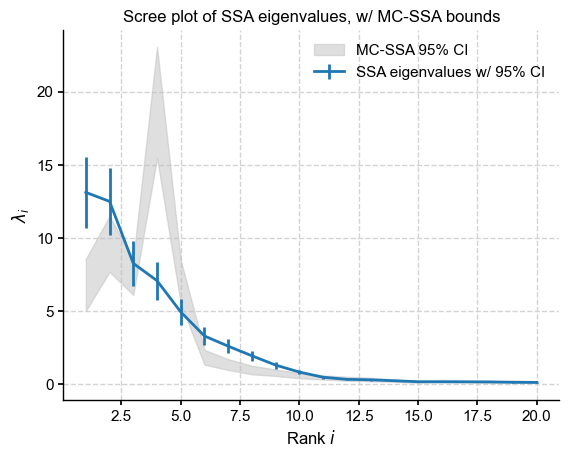

In [7]:
d  = nino_mcssa['eigvals'] # extract eigenvalue vector
M = len(d)
de = d*np.sqrt(2/(M-1))
du = nino_mcssa['eigvals_q'][:,0]  # extract upper quantile of MC-SSA eigenvalues
dl = nino_mcssa['eigvals_q'][:,1]  # extract lower quantile of MC-SSA eigenvalues

# plot eigenvalues
f, ax = plt.subplots()
rk = np.arange(0,20)+1
plt.fill_between(rk,dl[:20],du[:20],color='silver',alpha=0.5,label='MC-SSA 95% CI')
plt.errorbar(rk,d[:20],yerr=de[:20],label='SSA eigenvalues w/ 95% CI')
plt.title('Scree plot of SSA eigenvalues, w/ MC-SSA bounds')
plt.xlabel('Rank $i$'); plt.ylabel(r'$\lambda_i$')
plt.legend(loc='upper right')
pyleo.showfig(f)

This suggests that modes 1, 2 and 6 to 9 fall above the red noise benchmark. Let us zoom in on those, and use them for pre-filtering prior to spectral analysis. 

## SSA pre-filtering

Let's first look at the spectrum of the raw index, using two  methods included in Pyleoclim: the Multi-Taper Method (MTM, **link to doc and/or notebook**) and the Weighted Wavelet Z transform (WWZ, **link to doc and/or notebook**)

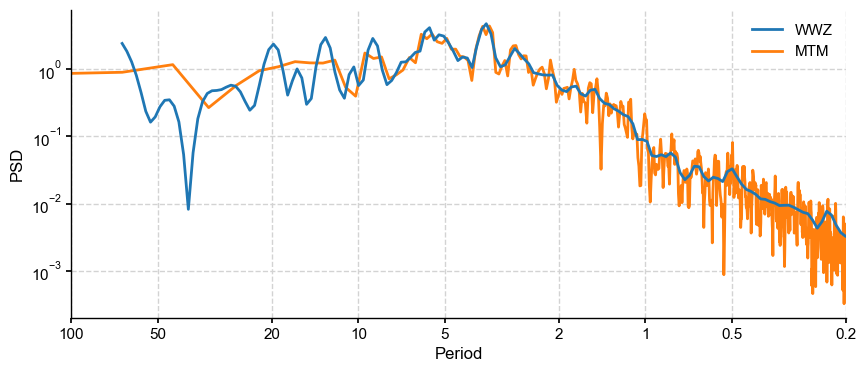

In [9]:
psd_wwz = ts_n.spectral()  # method='wwz' is the default 
psd_mtm = ts_n.interp().spectral(method='mtm', settings={'NW': 2})
fig, ax = psd_wwz.plot(label='WWZ', mute=True, zorder=99)
ax = psd_mtm.plot(ax=ax, label='MTM')
pyleo.showfig(fig)

Here we see clear interannual peaks, particular the [quasi-quadriennial](https://link.springer.com/article/10.1007/BF00223723) one (around 4 years, as the name implies). MTM with default parameters smoothes out the decadal-to-centennial part of the spectrum, but produces a lot of peaks at periods shorter than 2 years.  In contrast, WWZ smoothes out these high-frequency features, but shows peaks in the decadal range that MTM, certainly, does not see. Would pre-filtering NINO3 using the most robust SSA modes help with that? Also, are each of the interannual peaks carried by individual oscillations that a linear method like SSA could separate?

Before we answer these questions, let's write a little dashboard function for each mode, showing the corresponding T-EOF, RC, and spectra.

In [12]:
def SSA_modeinspection(m=0, NW = 2):
    EOF = nino_ssa['eigvecs'][:,m] 
    RC = nino_ssa['RCmat'][:,m]    

    fig = plt.figure(tight_layout=True,figsize=(10,5))
    gs = gridspec.GridSpec(2, 2) # plot RC
    ax = fig.add_subplot(gs[0, :])
    ax.plot(t,RC)
    ax.set_xlabel('year')
    ax.set_title('Mode '+str(m+1)+' RC, '+ '{:3.2f}'.format(var_pct[m]) + '% variance explained')
    # plot T-EOF
    ax = fig.add_subplot(gs[1, 0])
    ax.plot(EOF)
    ax.set_title('T-EOF (analyzing function)')
    ax.set_xlabel('months'), ax.set_ylabel('T-EOF values')
    # plot spectrum
    ax = fig.add_subplot(gs[1, 1])
    ts_rc = pyleo.Series(time=t, value=RC) # define timeseries object for the RC
    psd_mtm_rc = ts_rc.interp().spectral(method='mtm', settings={'NW': NW})
    #psd_wwz_rc = ts_rc.spectral()  
    #_ = psd_wwz_rc.plot(ax=ax, label='WWZ')
    _ = psd_mtm_rc.plot(ax=ax, label='MTM')
    ax.set_xlabel('Period (years)')
    ax.set_title('RC Spectra')
    pyleo.showfig(fig)
    
    return fig, ax 

Now let's use it! First, mode 1.

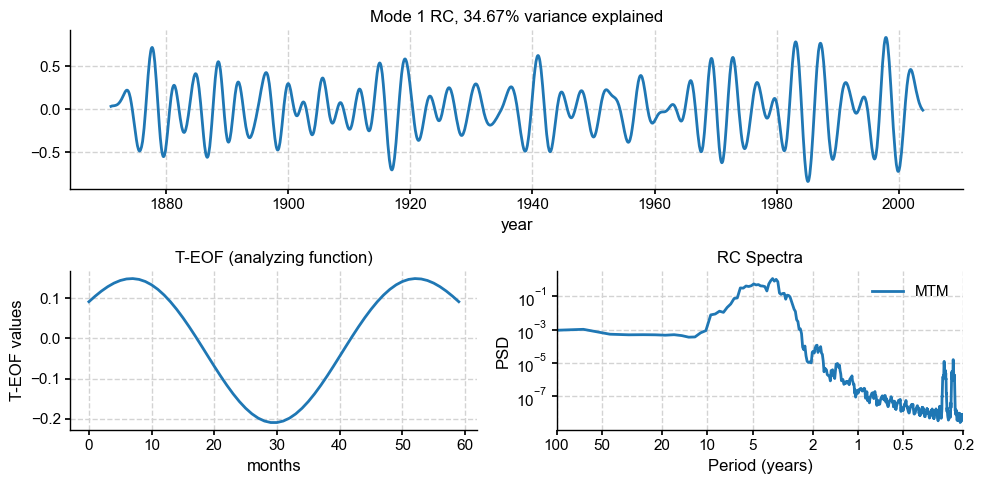

(<Figure size 1000x500 with 3 Axes>,
 <AxesSubplot:title={'center':'RC Spectra'}, xlabel='Period (years)', ylabel='PSD'>)

In [13]:
SSA_modeinspection(0)

This first mode, with nearly 35% of the variance, is associated with a nearly pure sinusoid with a period near 48 months. The two peaks near 0.2 years are strange, and in need of an explanation.  Now mode 2:

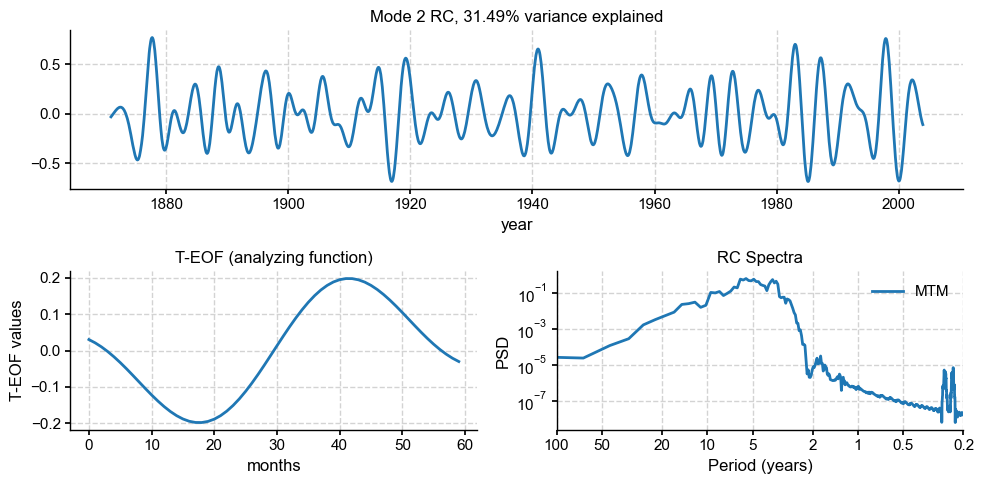

(<Figure size 1000x500 with 3 Axes>,
 <AxesSubplot:title={'center':'RC Spectra'}, xlabel='Period (years)', ylabel='PSD'>)

In [14]:
SSA_modeinspection(1)

Mode 2 has a nearly similar spectral signature as mode 1, consistent with those two modes being part of a pair. Its T-EOF is (by construction) orthogonal to that of mode 1, and one may think of them as a sine/cosine pair for this particular oscillation around 4 years. Together, they account for about 2/3 of the total variance.  What about modes 6 to 9?

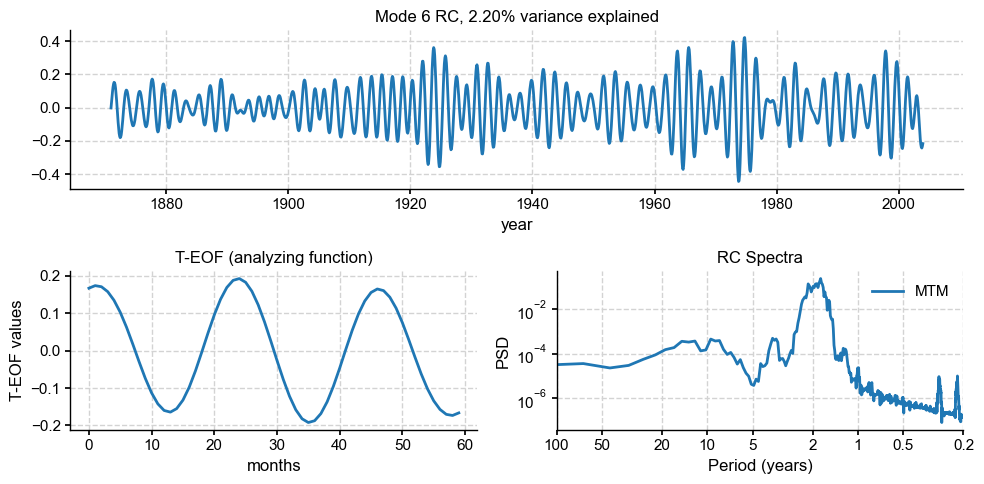

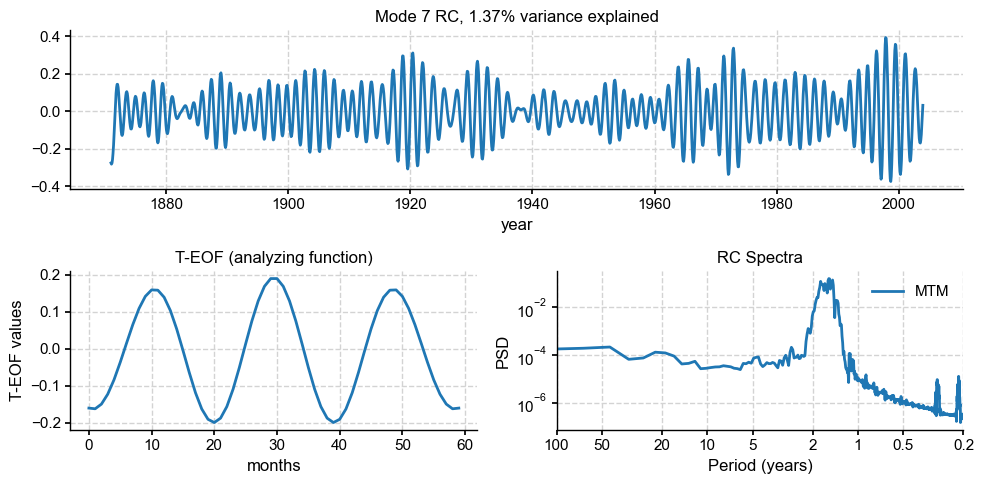

(<Figure size 1000x500 with 3 Axes>,
 <AxesSubplot:title={'center':'RC Spectra'}, xlabel='Period (years)', ylabel='PSD'>)

In [15]:
SSA_modeinspection(5)
SSA_modeinspection(6)

Modes 5 and 6 are associated with oscillations around 2 years, though the peaks are again fairly broad, indicative of low-frequency modulation (as evidenced in the envelope of these ~2y cycles). To refine the spectral estimate for these features, one could:
1. play with the time-bandwidth product ($NW$) of MTM.
1. apply other techniques better suited to detecting narrow-band peaks (e.g. Burg's method).  
1. apply yet other methods suited for nonlinear and non-stationary signals, like the Hilbert-Huang Transform.

Such is not our purpose, so we move instead to prefiltering using the modes identified above.

Finally, modes 8 and 9:

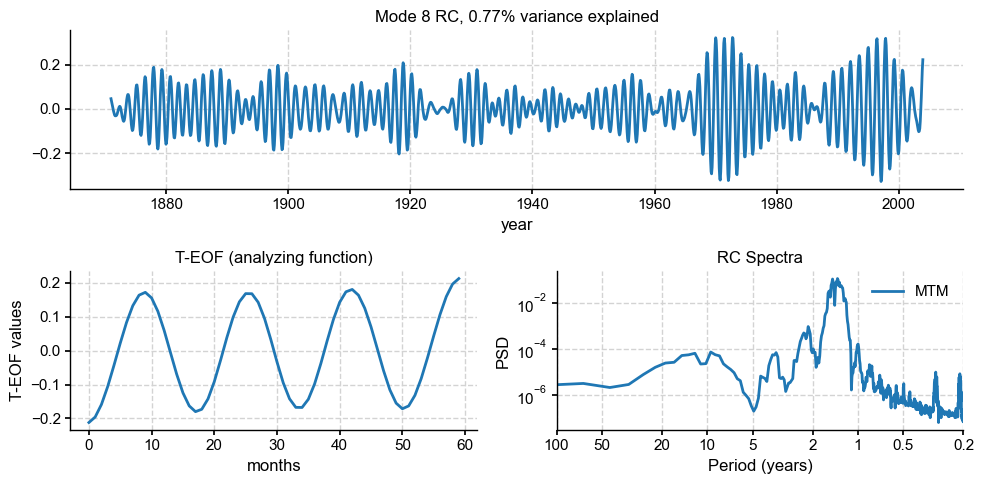

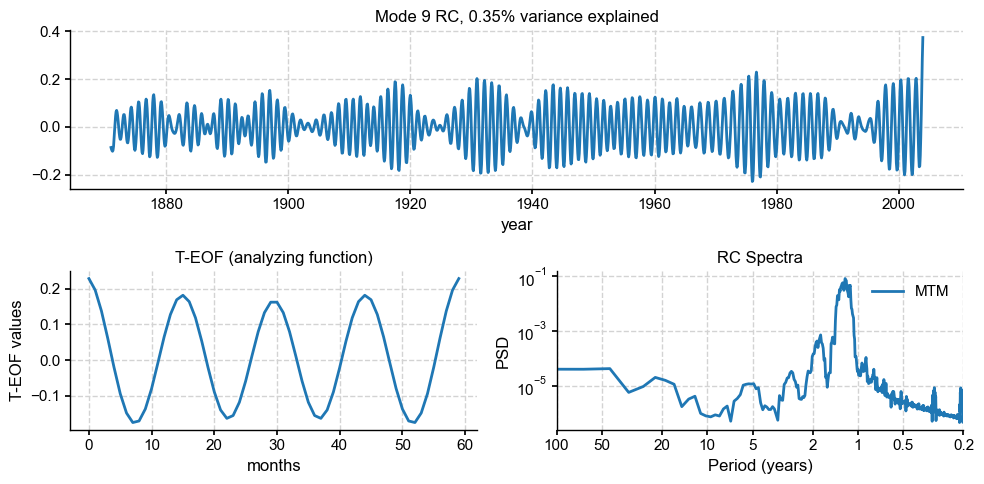

(<Figure size 1000x500 with 3 Axes>,
 <AxesSubplot:title={'center':'RC Spectra'}, xlabel='Period (years)', ylabel='PSD'>)

In [16]:
SSA_modeinspection(7)
SSA_modeinspection(8)

Those also have a nearly harmonic (sinusoidal) structure, with a shorter period between 1 and 2 years. Again, they seem to form a pair.  Overall, we see that, as we go up the ranks, the period of oscillation diminishes, as does the variance (by construction). That is again a common property of geophysical timeseries, which tend to be "warm colored" (more spectral energy at lower frequencies).

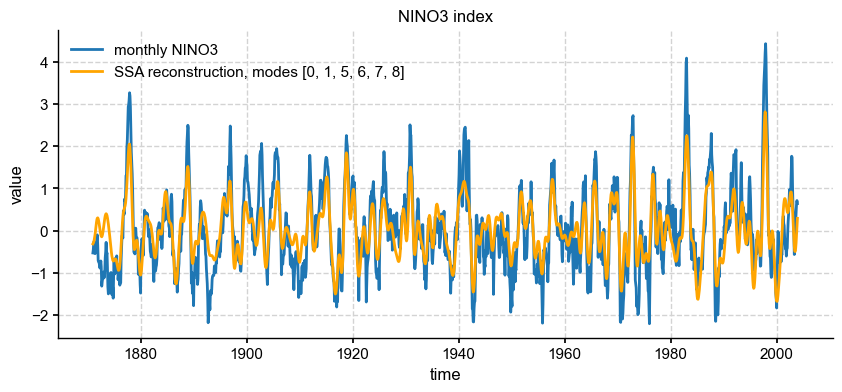

In [18]:
modes = [0 ,1, 5, 6, 7 ,8]
RCp = nino_ssa['RCmat'][:,modes].sum(axis=1)
fig, ax = ts_n.plot(title='NINO3 index',mute=True,label='monthly NINO3') # we mute the first call to only get the plot with 2 lines
ax.plot(t,RCp,label='SSA reconstruction, modes '+str(modes),color='orange')
ax.legend()
pyleo.showfig(fig)

What was in the modes excluded by MC-SSA, you ask? Let's have a look.

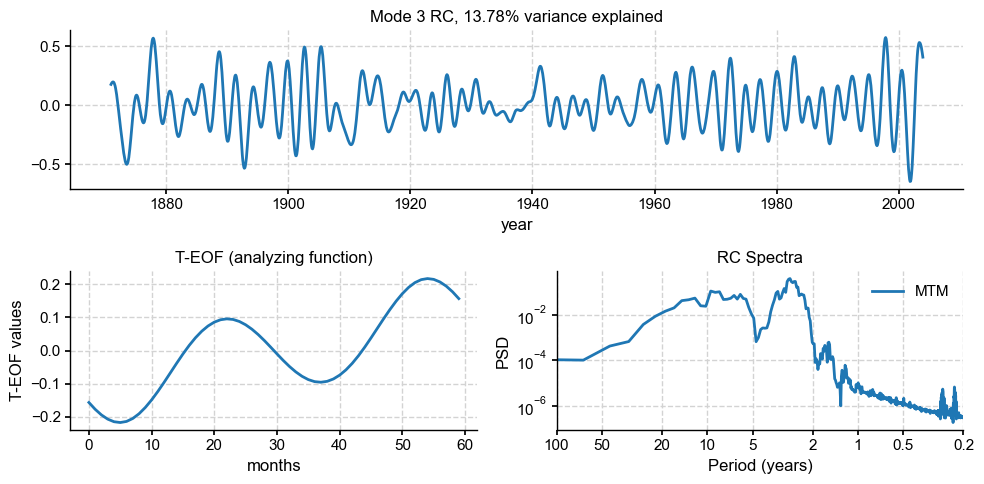

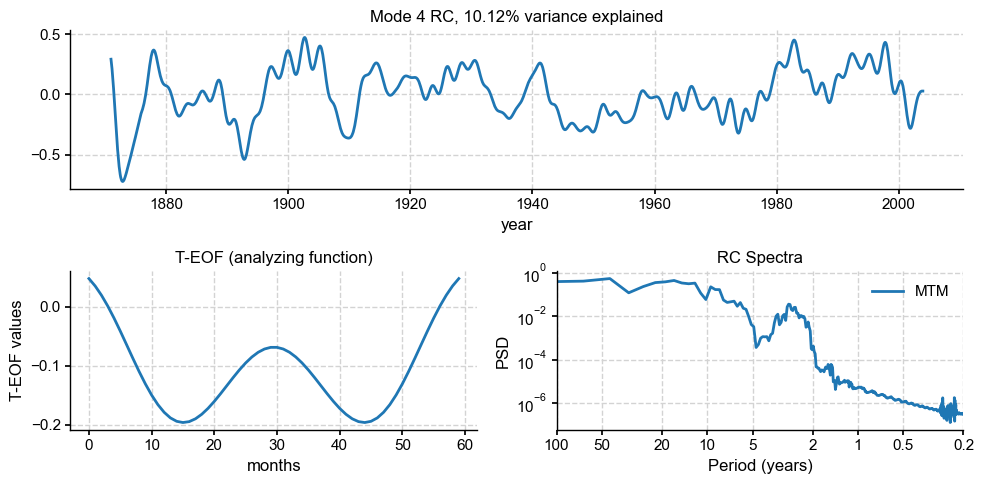

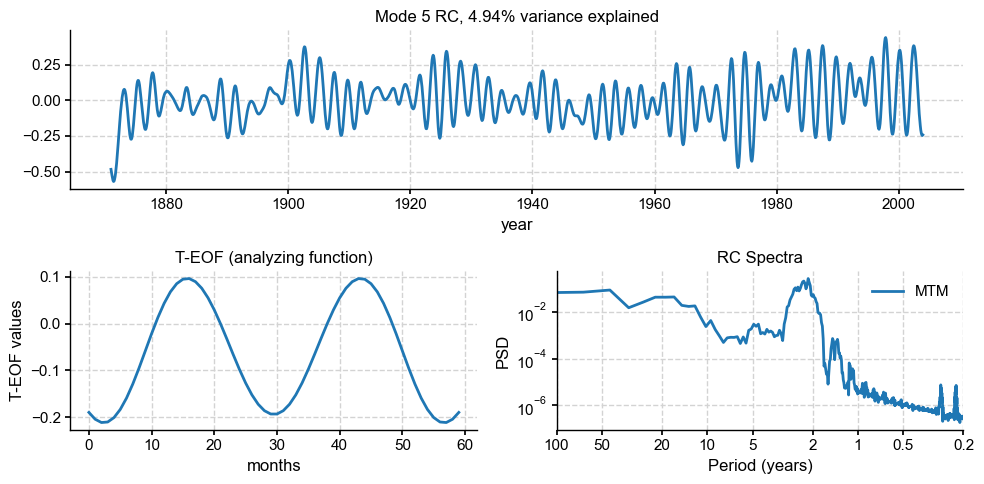

(<Figure size 1000x500 with 3 Axes>,
 <AxesSubplot:title={'center':'RC Spectra'}, xlabel='Period (years)', ylabel='PSD'>)

In [19]:
SSA_modeinspection(2)
SSA_modeinspection(3)
SSA_modeinspection(4)

Those modes contained a lot of low-frequency signals (compare their spectra to those of the other modes), some associated with trends in variance. However, these signals do not stand out compared to red noise, which is why MC-SSA left them out. Note that with different choices of embedding dimension ($M$), different modes will capture different features.

However, it is generally true over a broad range of choices that the MC-SSA modes capture most of the features of interest, including the various ENSO events. Let us now perform spectral analysis on a version of the timeseries that includes only those modes: 

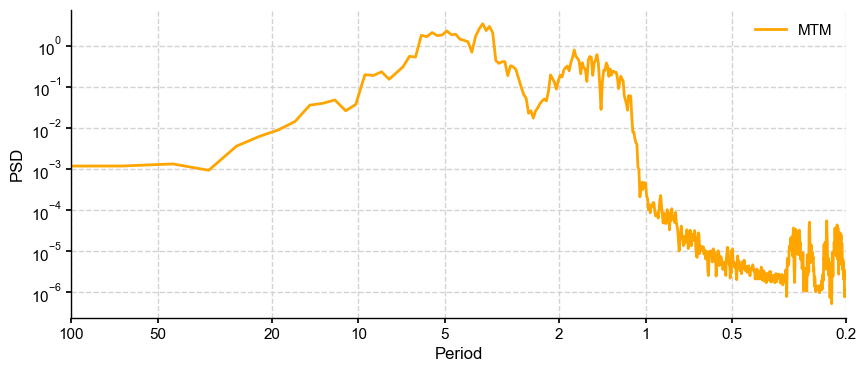

In [21]:
ts_rc = pyleo.Series(time=t, value=RCp) # create timeseries object 
psd_mtm = ts_rc.interp().spectral(method='mtm', settings={'NW': 2}) # apply MTM spectral analysis
fig, ax = psd_mtm.plot(label='MTM', mute=True, color='orange') # plot it
pyleo.showfig(fig)

We see indeed the variance concentrated in the interannual range, 1 to 8 years. Apart from the secondary peak around 0.2-0.4, the signal is overall much cleaner than before, illustrating the beneficial effects of SSA to filter signals of interest prior to applying spectral analysis. 

In future versions, various truncation criteria will be implemented to allow easy SSA filtering, without having to explore individual modes. However, it is highly advisable to look at the eigenvalue spectrum before tinkering too much.

## SSA with missing values

The last feature of the `pyleoclim` implementation of SSA is the ability to deal with missing values, which is particularly critical in the paleosciences, where data are seldom sampled at regular time intervals. 
It turns out that SSA can also be applied on timeseries that contain a reasonable amount of missing data, thanks to the work of [Schoellhamer (2001)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2000GL012698). To illustrate this, we simply dig some holes in the NINO3 series, apply SSA, and compare the results for various fractions of missing values. 

In [22]:
n = len(nino)
fm = 0.1  #fraction of missing values
missing = np.random.choice(n,np.floor(fm*n).astype('int'),replace=False)

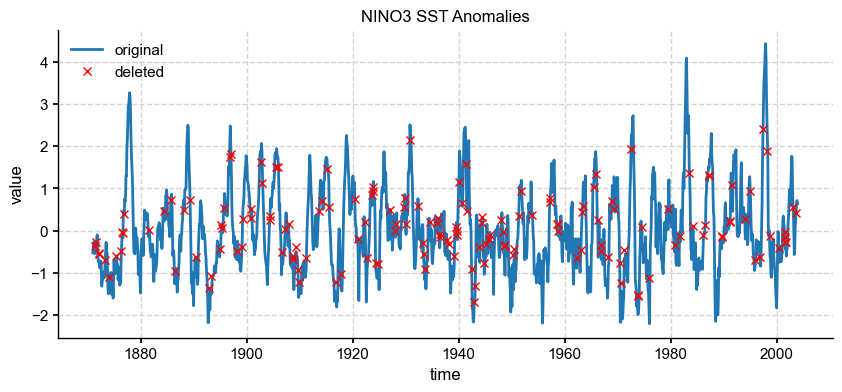

In [23]:
fig, ax = ts_n.plot(title='NINO3 SST Anomalies',mute=True,label='original')
ax.plot(t[missing],nino[missing],'rx',label='deleted')
ax.legend()
pyleo.showfig(fig)

Now let's apply SSA to the incomplete data (blue minus red)

In [25]:
nino_miss = np.copy(ts_n.value)
nino_miss[missing] = np.nan  # put NaNs at the randomly chosen locations
ts_miss = pyleo.Series(time=t,value=nino_miss, clean_ts=False)
miss_ssa = ts_miss.ssa(M = 60, trunc='var',var_thresh=95)

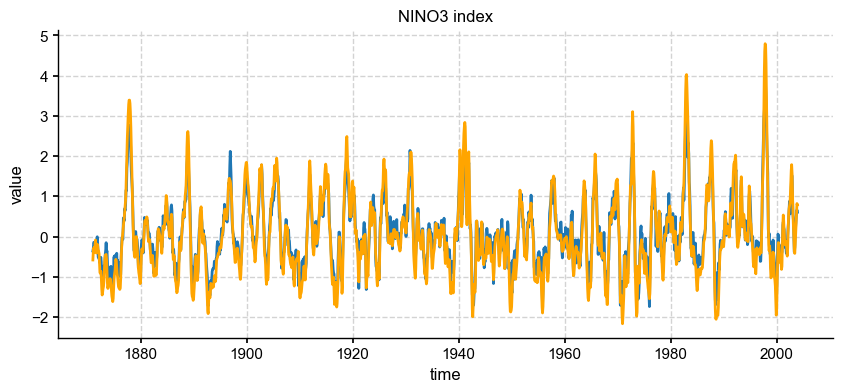

In [27]:
RCmiss = miss_ssa['RCmat'][:,:19].sum(axis=1)
fig, ax = ts_nino.plot(title='NINO3 index',mute=True) # we mute the first call to only get the plot with 2 lines
ax.plot(t,RCmiss,label=r'gappy SSA reconstruction, $k=20$',color='orange')
pyleo.showfig(fig)

We see that, despite missing 10% of the values, a low-order (20 mode) SSA synthesis is able to successfully capture the behavior of the original timeseries, much as it did before. Two questions: what happens if we use more or fewer modes? And what would happen with larger fractions of missing values? Let's find out.

First, we truncate the SSA expansion so it includes only modes that include 95% of the variance. This is set with `trunc='var',var_thresh=95` above, and the result is:

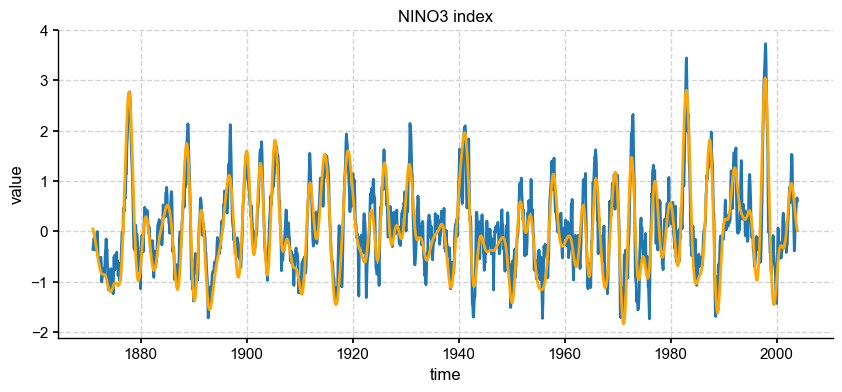

In [28]:
RCmiss = miss_ssa['RCseries']
fig, ax = ts_nino.plot(title='NINO3 index',mute=True) # we mute the first call to only get the plot with 2 lines
ax.plot(t,RCmiss,label=r'gappy SSA reconstruction, 95% variance',color='orange')
pyleo.showfig(fig)

The series is a little smoother, which may not be a bad thing if you suspect there is some noise in your series. If not, you may decide to keep those 20 modes, and see what happens as the data become sparser: 

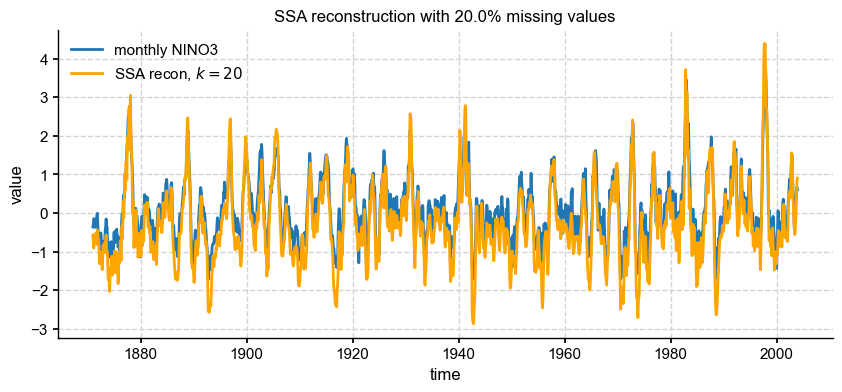

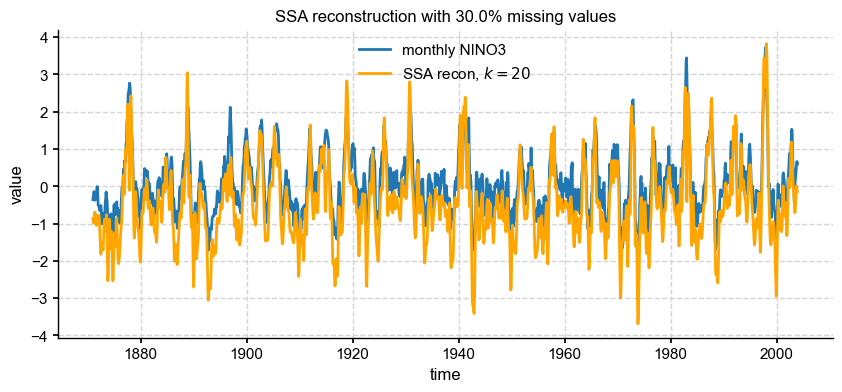

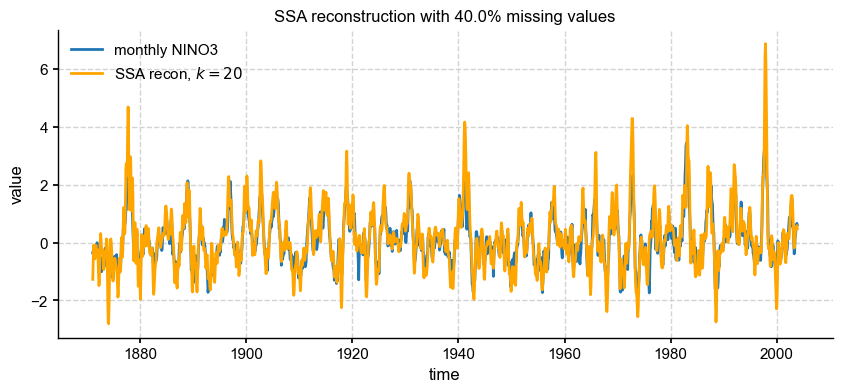

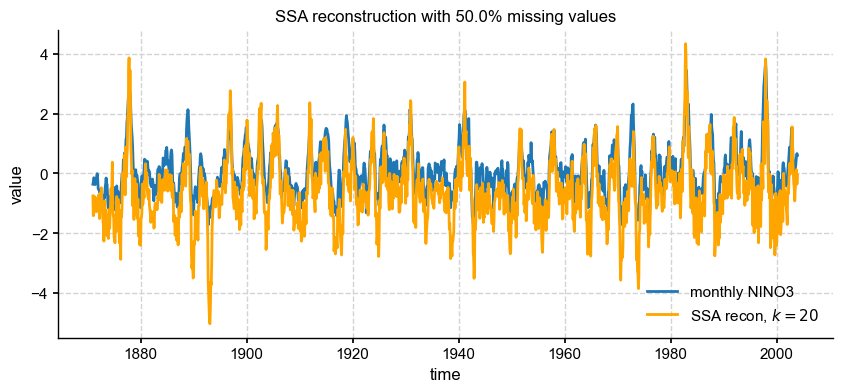

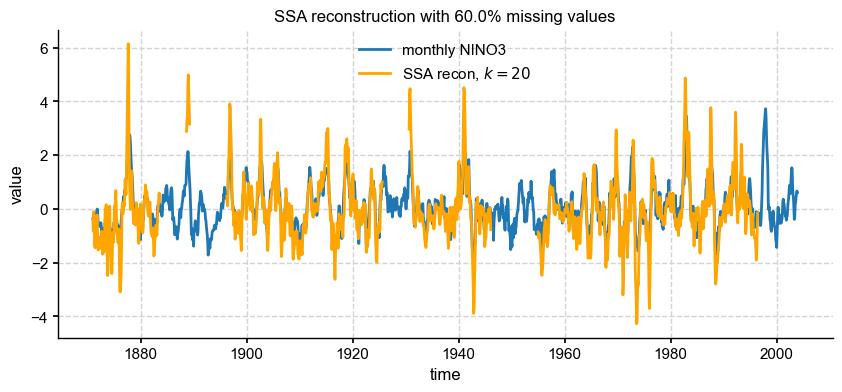

In [29]:
fmiss = [.2, .3, .4, .5, .6]

for fm in fmiss:
    missing = np.random.choice(n,np.floor(fm*n).astype('int'),replace=False)
    nino_miss = np.copy(ts_n.value)
    nino_miss[missing] = np.nan
    ts_miss = pyleo.Series(time=t,value=nino_miss, clean_ts=False)
    miss_ssa = ts_miss.ssa(M = 60)
    RCmiss = miss_ssa['RCmat'][:,:19].sum(axis=1)
    fig, ax = ts_nino.plot(title=r'SSA reconstruction with '+ str(fm*100) +'% missing values',mute=True,label='monthly NINO3')
    ax.plot(t,RCmiss,label='SSA recon, $k=20$',color='orange')
    ax.legend()
    pyleo.showfig(fig)

We see that SSA still does a decent job with only half the points ($f = .50$), however the reconstruction degrades very quickly above that. It's already shabby at 60%, and more would be a sight for sore eyes. Obviously, trying to reconstruct such a complex signal based on fewer samples than that is asking for trouble. In fact, it's already rather impressive that SSA can extract so much information from so few data. That is a testimony to the idea that most communication is [redundant](https://en.wikipedia.org/wiki/Information_theory), which is the basis of compression,  used so ubiquitously in the digital world (think mp3 audio files, jpeg photographs, etc). You may in fact think of this SSA reconstruction as a form of data compression. 

Now, this data compression is a lot easier when the data are missing at random, as was the case here. If we were to take out a contiguous chunk of the data , things would go sour very fast. Let's see that by taking out the second quarter of the series:

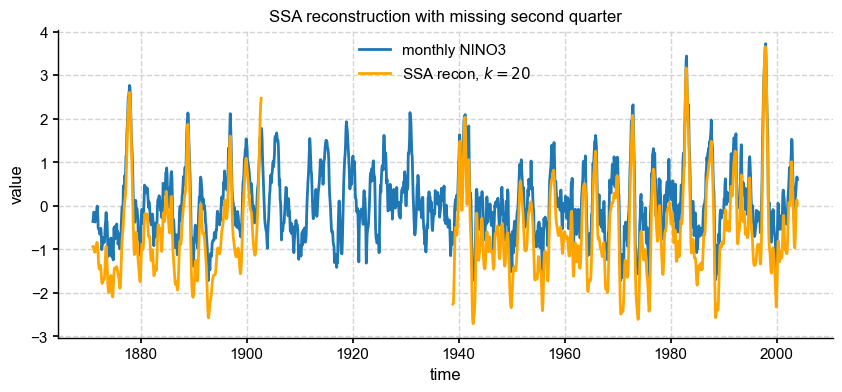

In [31]:
missing = np.arange(np.floor(n/4),np.floor(n/2),dtype='int')
nino_miss = np.copy(ts_n.value)
nino_miss[missing] = np.nan
ts_miss = pyleo.Series(time=t,value=nino_miss,clean_ts=False)
miss_ssa = ts_miss.ssa(M = 60)
RCmiss = miss_ssa['RCmat'][:,:19].sum(axis=1)
fig, ax = ts_nino.plot(title=r'SSA reconstruction with missing second quarter',mute=True,label='monthly NINO3')
ax.plot(t,RCmiss,label='SSA recon, $k=20$',color='orange')
ax.legend()
pyleo.showfig(fig)

Here, the missing 25% could not be inferred, so SSA simply it left it out.  

In summary, SSA may be used for **interpolation** (that is, the **imputation of missing values**): instead of traditional methods like polynomial interpolation, it provides an alternative that leverages the underlying oscillatory components of the timeseries. However, the method canmot perform miracles, and works best when data are missing in non-contiguous blocks. At present, it does not provide error estimates around interpolated values, though one could imagine generalizations that do. Methods such as [these](https://onlinelibrary.wiley.com/doi/full/10.1002/cmm4.1080) might be helpful. 

## SSA approximation
Like all decomposition methods, SSA may be used to obtain approximations to the original series, often with the idea of filtering out noise. We've already seen how Monte Carlo SSA can be used for selecting relevant modes' `Pyleoclim` also implements two simpler (and computationally light) options: the Kaiser rule, and a criterion on retained variance used above (the amount of variance retained is dictated by the optinal parameter `var_thresh`).  The Kaiser rule (sometimes called Kaiser Guttman rule) asserts that the modes that matter are those whose eigenvalue is above the mean (or median) of the eigenvalues.  Let us compare these three criteria:

In [34]:
kaiser = ts_n.ssa(M = 60, trunc = 'kaiser')
mc_ssa = ts_n.ssa(M = 60, trunc = 'mcssa',nMC=400)
var    = ts_n.ssa(M = 60, trunc = 'var', var_thresh=95)

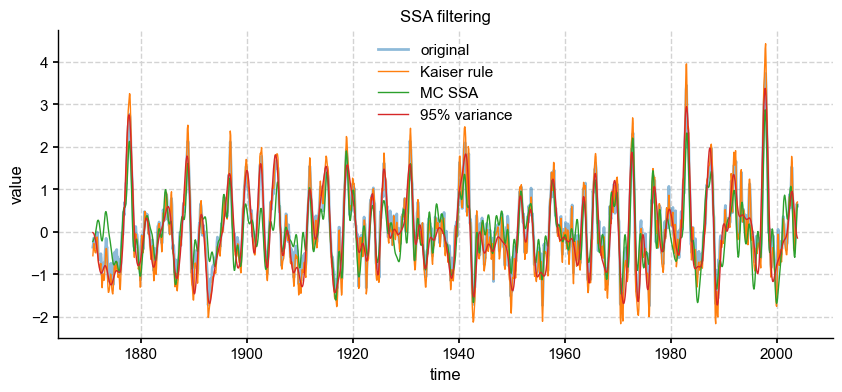

In [35]:
fig, ax = ts_nino.plot(title=r'SSA filtering',mute=True,label='original',alpha=0.5)
alp=1
ax.plot(t,kaiser['RCseries'],label='Kaiser rule',alpha=alp,lw=1)
ax.plot(t,mc_ssa['RCseries'],label='MC SSA',alpha=alp,lw=1)
ax.plot(t,var['RCseries'],label='95% variance',alpha=alp,lw=1)

ax.legend()
pyleo.showfig(fig)

One can see that the various methods come out with comparable approximations to the original series, all tending to lower high-frequency oscillations. One caveat is that variance is not preserved, so this should be kept in mind in case variance matters ot your analysis. 

There would be other methods, like Equation 26 in [Nadakuditi & Edelman (2008)](https://doi.org/10.1109/TSP.2008.917356), which have yet to be implemented.

## Conclusion
This concludes our overview of SSA in `Pyleoclim`.

Note: for the latest updates, install the dvlpt branch of pyleoclim with `pip install -U git+https://github.com/LinkedEarth/Pyleoclim_util.git@Development`